In [1]:
import reader as rd
from matplotlib import pyplot as plt
import processing_data as pd
import numpy as np
import angular as ang

In [2]:
'''
Set Datafolder and load the Data here.
'''
acc, gyro = rd.csv_to_array(folder='dataset/track_geb64/', delimiter=';')
sampling_rate = rd.get_sample_freq(acc)
time_window = 30
crop_factor = 50 # need to be 50 for geb 64 else 2



<function matplotlib.pyplot.show(close=None, block=None)>

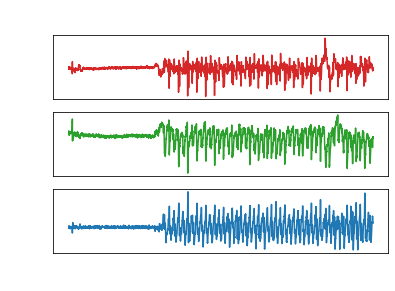

In [3]:
'''
Plot first 20 seconds of Data raw Data
'''
time_total = [i[0] for i in acc]
time = time_total[:time_window*sampling_rate]

x_acc = [i[1] for i in acc][:time_window*sampling_rate]
y_acc= [i[2] for i in acc][:time_window*sampling_rate]
z_acc = [i[3] for i in acc][:time_window*sampling_rate]

fig, axs = plt.subplots(3)

fig.suptitle('Raw Acceleration Data', color='white')

axs[0].plot(time, x_acc, 'tab:red')
axs[0].set(ylabel='x_acceleration')
axs[1].plot(time, y_acc, 'tab:green')
axs[1].set(ylabel='y_acceleration')
axs[2].plot(time, z_acc, 'tab:blue')
axs[2].set(ylabel='z_acceleration')

for a in axs:
    a.set(xlabel='time')
    a.tick_params( colors='white')
    a.xaxis.label.set_color('white')
    a.yaxis.label.set_color('white')
plt.show

In [4]:
'''
preprocess, normalize acc data and use peak detection algorithm to calculate steps
'''
prepro_acc = pd.remove_time_dim(data=acc,sample_freq=sampling_rate)
prepro_acc = pd.acc_lowpass_filter(prepro_acc, sampling_rate)
step_count, steps_index, norm_accel = pd.peakfinder(prepro_acc, sampling_rate)



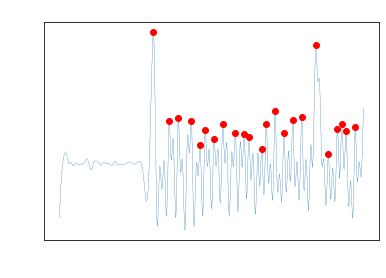

In [5]:
'''
visualize the normalized acc_data + mark the peaks = steps
'''
fig = plt.figure()
ax = fig.gca()

norm_accel =  norm_accel[:int(time_window*sampling_rate)]
time  = np.array(time)
ax.plot(time, norm_accel, linewidth=0.3, zorder=-1, color='tab:blue')
steps = steps_index[steps_index < len(time)]
ax.scatter(time[steps], norm_accel[steps], c='r', marker='o')
ax.set(xlabel='time in seconds', ylabel='normalized acceleration', title='Estimated Steps')
ax.tick_params( colors='white')
ax.title.set_color('white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')

In [6]:
'''
print some Numbers here acording to steps here
'''
print("Estimated number of steps in this Timewindow: "+str(len(steps)))
print("Total estimated number of steps for filtered data: "+str(step_count))

Estimated number of steps in this Timewindow: 23
Total estimated number of steps for filtered data: 165


In [7]:
'''
preprocess gyroscope data + calculate all g_b_dash vectors
'''
prepro_gyro = pd.remove_time_dim(data=gyro, sample_freq=sampling_rate)

initial_g_b_dash = ang.calc_initial_g_b_dash(acc_data=prepro_acc,len_init_time=9,freq=sampling_rate)
all_g_b_dash = ang.calc_all_g_b_dash(acc_data=prepro_acc,initial_g_b_dash=initial_g_b_dash,m=0.7)

In [8]:
'''
Angular Algorithm
'''
w_turn_angle_z = np.zeros(len(time_total)-crop_factor)
turn_angle = np.zeros(len(time_total)-crop_factor)
for k in range (1, len(time_total)-crop_factor):
    r_t = np.transpose(ang.calc_rotation_matrix(g_b_dash=all_g_b_dash[k])) #calc rotation matrix for g_b_dash at time k
    w_turn_angle_z[k] = np.matmul(r_t, prepro_gyro[k])[2] #compute turn angle by using gyro data + transmit using r_t

    delta_time = time_total[k] - time_total[k-1] # compute the delta between time t and t-1
    turn_angle[k - 1] = w_turn_angle_z[k] * delta_time

    # instead of building some for every element, saving summ in previous Element
    # Fibonacci summ
    if k >= 2:
        turn_angle[k - 1] += turn_angle[k - 2]

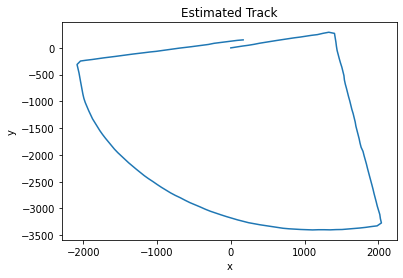

In [9]:
'''
plot track using step estimation, estimated turning angle, step length
'''

# calculate coordinates
x = np.zeros(step_count+1)
y = np.zeros(step_count+1)
lambda_t =  80  # step length in cm, different for the two members of the group
for step in range(1, step_count+1):
    x[step] = x[step - 1] + lambda_t * np.cos(turn_angle[steps_index[step - 1]])
    y[step] = y[step - 1] + lambda_t * np.sin(turn_angle[steps_index[step - 1]])

fig = plt.figure()
ax = fig.gca()
ax.plot(x, y)
ax.set(xlabel='x', ylabel='y', title='Estimated Track')
plt.show()